In [144]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

In [145]:
import os

base_dir = os.path.abspath('')
path = os.path.join(base_dir, '../Przetwarzanie Danych/')
co2_production = pd.read_csv(path + 'co2_production.csv')
gni_per_capita = pd.read_csv(path + 'gross_national_income_per_capital.csv')
hdi = pd.read_csv(path + 'human_development_index.csv')
life_expectancy = pd.read_csv(path + 'life_expectancy_by_birth.csv')

all_data = life_expectancy.copy()

In [146]:
for dataframe in [co2_production, gni_per_capita, hdi]:
    all_data = all_data.merge(dataframe, on='Country', how='outer', suffixes=('', '_drop'))

all_data = all_data[all_data.columns.drop(list(all_data.filter(regex='_drop')))]

columns_to_drop = ['ISO3', 'hdicode', 'hdi_rank_2021']
all_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')


all_data['avg_co2'] = all_data.filter(like='co2_prod_').mean(axis=1)
all_data['avg_gni'] = all_data.filter(like='gnipc_').mean(axis=1)  

In [147]:
for year in range(1990, 2022):
    co2_column_name = f"co2_prod_{year}"
    gni_column_name = f"gnipc_{year}"
    estimated_population_column_name = f"estimated_population_{year}"
    co2_per_capita_column_name = f"co2_per_capita_{year}"
    
    if co2_column_name in all_data.columns and gni_column_name in all_data.columns:
        all_data[estimated_population_column_name] = all_data[co2_column_name] / all_data[gni_column_name]
        all_data[co2_per_capita_column_name] = all_data[co2_column_name] / all_data[estimated_population_column_name]


print(all_data['avg_co2'].describe())
print(all_data['avg_gni'].describe())

count    204.000000
mean       4.499696
std        5.972266
min        0.038186
25%        0.639804
50%        2.227585
75%        6.370562
max       48.440912
Name: avg_co2, dtype: float64
count       204.000000
mean      16488.239856
std       18703.085972
min         841.037957
25%        3768.881573
50%        9515.751330
75%       20114.611191
max      111709.939782
Name: avg_gni, dtype: float64


count    2.030000e+02
mean     1.566113e+05
std      3.924014e+05
min      3.296368e+01
25%      2.633570e+03
50%      2.370363e+04
75%      1.220875e+05
max      3.970303e+06
Name: co2_gni_interaction, dtype: float64
count    202.000000
mean       0.719564
std        0.148600
min        0.385000
25%        0.603250
50%        0.735500
75%        0.830500
max        0.962000
Name: hdi_2021, dtype: float64


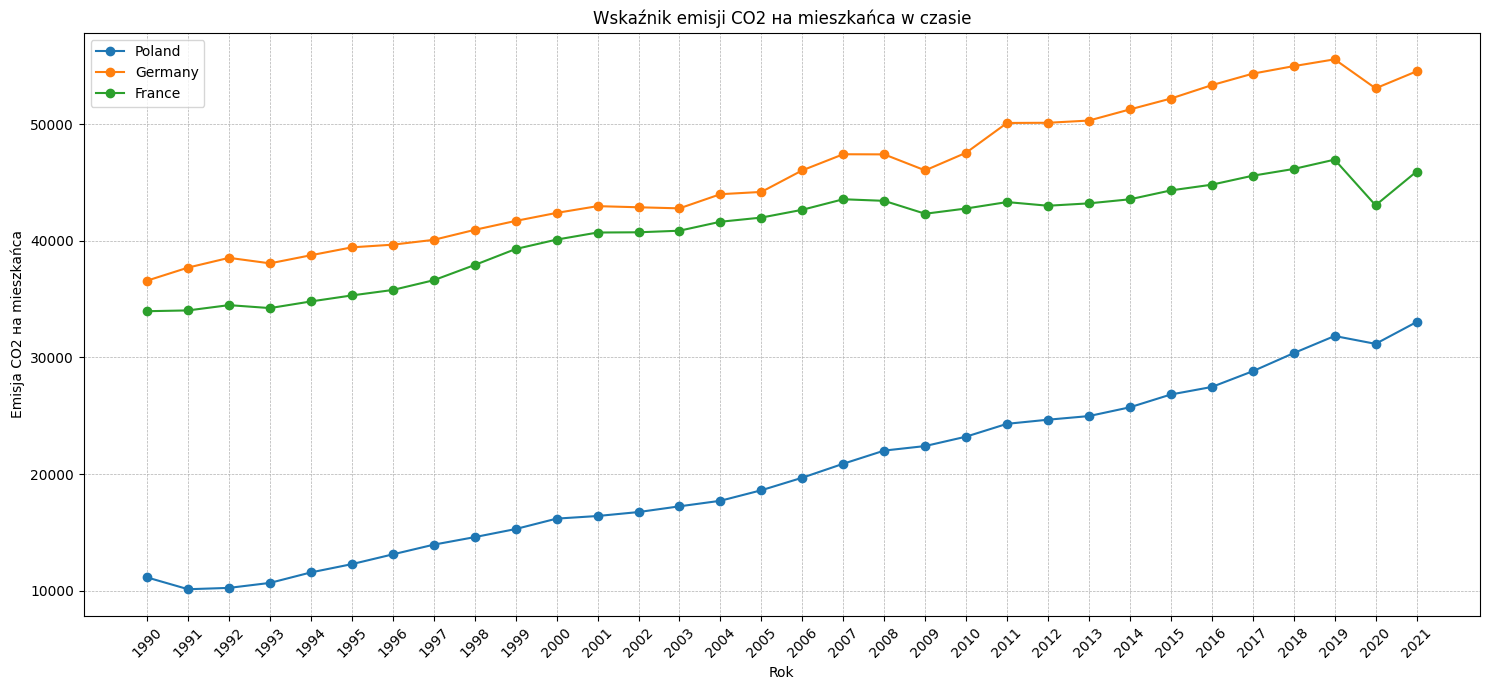

In [148]:
all_data['co2_gni_interaction'] = all_data['avg_co2'] * all_data['avg_gni']


selected_countries = ["Poland", "Germany", "France"]

plt.figure(figsize=(15,7))
for country in selected_countries:
    country_data = all_data[all_data['Country'] == country]
    years = range(1990, 2022)
    co2_per_capita_values = []

    for year in years:
        col_name = f'co2_per_capita_{year}'
        if col_name in country_data.columns:
            co2_per_capita_values.append(country_data[col_name].values[0])
        else:
            co2_per_capita_values.append(None)

    available_years = [year for year, value in zip(years, co2_per_capita_values) if value is not None]
    available_values = [value for value in co2_per_capita_values if value is not None]

    plt.plot(available_years, available_values, label=country, marker='o')

plt.title("Wskaźnik emisji CO2 на mieszkańca w czasie")
plt.xlabel("Rok")
plt.ylabel("Emisja CO2 на mieszkańca")
plt.xticks(range(1990, 2022), rotation=45)
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
print(all_data['co2_gni_interaction'].describe())
print(all_data['hdi_2021'].describe())

plt.show()

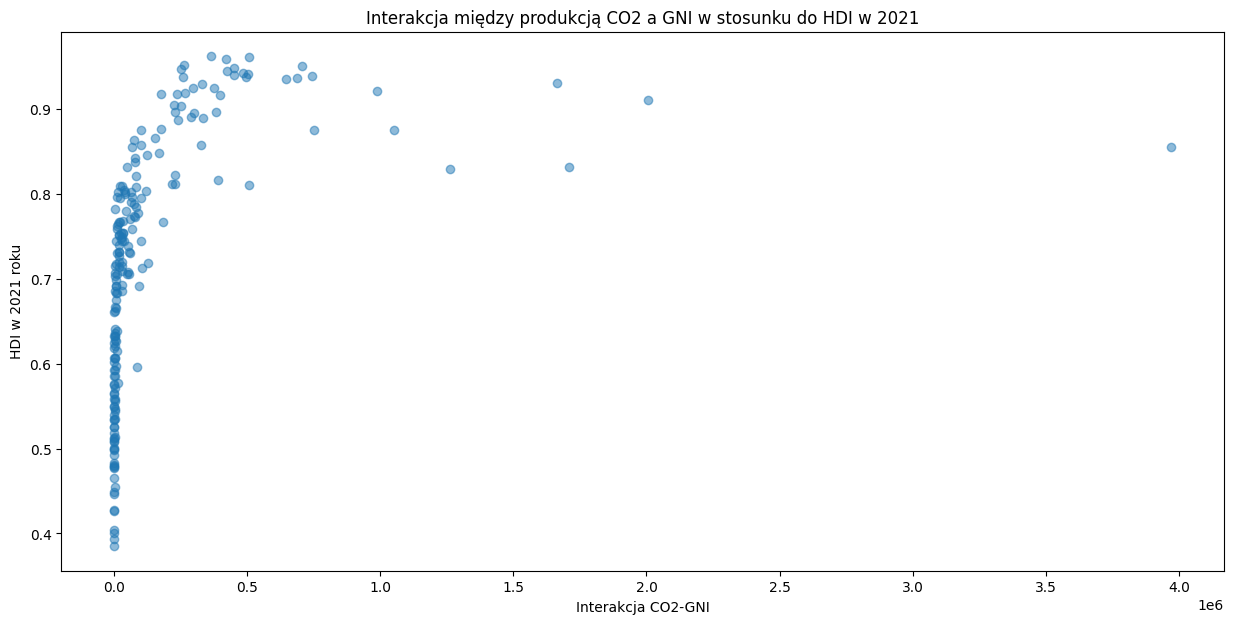

In [149]:
plt.figure(figsize=(15, 7))

plt.scatter(all_data['co2_gni_interaction'], all_data['hdi_2021'], alpha=0.5)
plt.title('Interakcja między produkcją CO2 a GNI w stosunku do HDI w 2021')
plt.xlabel('Interakcja CO2-GNI')
plt.ylabel('HDI w 2021 roku')
plt.show()

In [150]:
for col in all_data.columns:
    if all_data[col].dtype == 'object':
        all_data[col].fillna(all_data[col].mode()[0], inplace=True)
    else:
        all_data[col].fillna(all_data[col].mean(), inplace=True)

encoder = OneHotEncoder(drop='first')
encoded_region = encoder.fit_transform(all_data[['region']])
encoded_region_df = pd.DataFrame(encoded_region.toarray(), columns=encoder.get_feature_names_out(['region']))
all_data = pd.concat([all_data.drop(['region'], axis=1), encoded_region_df], axis=1)

In [151]:
# numeric_columns = all_data.select_dtypes(include=['float64', 'int64']).columns
# scaler = MinMaxScaler()
# all_data[numeric_columns] = scaler.fit_transform(all_data[numeric_columns])

In [152]:
pd.set_option('display.max_columns', None)

In [153]:
all_data

,Country,le_1990,le_1991,le_1992,le_1993,le_1994,le_1995,le_1996,le_1997,le_1998,le_1999,le_2000,le_2001,le_2002,le_2003,le_2004,le_2005,le_2006,le_2007,le_2008,le_2009,le_2010,le_2011,le_2012,le_2013,le_2014,le_2015,le_2016,le_2017,le_2018,le_2019,le_2020,le_2021,co2_prod_1990,co2_prod_1991,co2_prod_1992,co2_prod_1993,co2_prod_1994,co2_prod_1995,co2_prod_1996,co2_prod_1997,co2_prod_1998,co2_prod_1999,co2_prod_2000,co2_prod_2001,co2_prod_2002,co2_prod_2003,co2_prod_2004,co2_prod_2005,co2_prod_2006,co2_prod_2007,co2_prod_2008,co2_prod_2009,co2_prod_2010,co2_prod_2011,co2_prod_2012,co2_prod_2013,co2_prod_2014,co2_prod_2015,co2_prod_2016,co2_prod_2017,co2_prod_2018,co2_prod_2019,co2_prod_2020,co2_prod_2021,gnipc_1990,gnipc_1991,gnipc_1992,gnipc_1993,gnipc_1994,gnipc_1995,gnipc_1996,gnipc_1997,gnipc_1998,gnipc_1999,gnipc_2000,gnipc_2001,gnipc_2002,gnipc_2003,gnipc_2004,gnipc_2005,gnipc_2006,gnipc_2007,gnipc_2008,gnipc_2009,gnipc_2010,gnipc_2011,gnipc_2012,gnipc_2013,gnipc_2014,gnipc_2015,gnipc_2016,gnipc_2017,gnipc_2018,gnipc_2019,gnipc_2020,gnipc_2021,hdi_1990,hdi_1991,hdi_1992,hdi_1993,hdi_1994,hdi_1995,hdi_1996,hdi_1997,hdi_1998,hdi_1999,hdi_2000,hdi_2001,hdi_2002,hdi_2003,hdi_2004,hdi_2005,hdi_2006,hdi_2007,hdi_2008,hdi_2009,hdi_2010,hdi_2011,hdi_2012,hdi_2013,hdi_2014,hdi_2015,hdi_2016,hdi_2017,hdi_2018,hdi_2019,hdi_2020,hdi_2021,avg_co2,avg_gni,estimated_population_1990,co2_per_capita_1990,estimated_population_1991,co2_per_capita_1991,estimated_population_1992,co2_per_capita_1992,estimated_population_1993,co2_per_capita_1993,estimated_population_1994,co2_per_capita_1994,estimated_population_1995,co2_per_capita_1995,estimated_population_1996,co2_per_capita_1996,estimated_population_1997,co2_per_capita_1997,estimated_population_1998,co2_per_capita_1998,estimated_population_1999,co2_per_capita_1999,estimated_population_2000,co2_per_capita_2000,estimated_population_2001,co2_per_capita_2001,estimated_population_2002,co2_per_capita_2002,estimated_population_2003,co2_per_capita_2003,estimated_population_2004,co2_per_capita_2004,estimated_population_2005,co2_per_capita_2005,estimated_population_2006,co2_per_capita_2006,estimated_population_2007,co2_per_capita_2007,estimated_population_2008,co2_per_capita_2008,estimated_population_2009,co2_per_capita_2009,estimated_population_2010,co2_per_capita_2010,estimated_population_2011,co2_per_capita_2011,estimated_population_2012,co2_per_capita_2012,estimated_population_2013,co2_per_capita_2013,estimated_population_2014,co2_per_capita_2014,estimated_population_2015,co2_per_capita_2015,estimated_population_2016,co2_per_capita_2016,estimated_population_2017,co2_per_capita_2017,estimated_population_2018,co2_per_capita_2018,estimated_population_2019,co2_per_capita_2019,estimated_population_2020,co2_per_capita_2020,estimated_population_2021,co2_per_capita_2021,co2_gni_interaction,region_EAP,region_ECA,region_LAC,region_SA,region_SSA
0,Afghanistan,45.967200,46.663100,47.595500,51.466400,51.494500,52.544200,53.243300,53.634200,52.943100,54.846400,55.297800,55.798100,56.453800,57.344500,57.943600,58.360800,58.684400,59.111300,59.851500,60.363600,60.850800,61.419100,61.923000,62.416700,62.545100,62.658700,63.136100,63.016000,63.081000,63.564500,62.575100,61.982400,0.209727,0.182525,0.095233,0.084285,0.075054,0.067943,0.061787,0.056005,0.052144,0.040133,0.036462,0.036931,0.046529,0.050083,0.035960,0.050802,0.061870,0.083711,0.151485,0.237367,0.287739,0.401954,0.327922,0.261571,0.232967,0.229680,0.190617,0.188995,0.224492,0.319299,0.312376,0.312376,2684.550019,2276.289409,2059.868084,1525.533426,1087.961890,1339.087122,1332.307210,1230.261290,1149.902390,1071.800919,984.997434,894.024589,1267.628852,1401.324413,1384.695729,1435.191730,1518.767846,1811.166659,1753.066993,1884.200863,1938.315627,1999.653042,2125.862821,2193.553936,2178.507021,2101.589319,2077.566899,2085.487571,2054.939895,2097.889450,1997.852149,1824.190915,0.273000,0.279000,0.287000,0.297000,0.292000,0.310000,0.319000,0.323000,0.324000,

In [154]:
df = pd.DataFrame(columns=["co2", "gnipc", "hdi", "region_EAP",	"region_ECA", "region_LAC", "region_SA", "region_SSA", "le"])
df


,co2,gnipc,hdi,region_EAP,region_ECA,region_LAC,region_SA,region_SSA,le


In [155]:
index = 0

for i, row in all_data.iterrows():
    for year in range(1990, 2022):
        new_row = {
            'co2': row[f'co2_per_capita_{year}'],
            'hdi': row[f'hdi_{year}'],
            'le': row[f'le_{year}'],
            'gnipc': row[f'gnipc_{year}'],
            'region_EAP': row['region_EAP'],
            'region_ECA': row['region_ECA'],
            'region_LAC': row['region_LAC'],
            'region_SA': row['region_SA'],
            'region_SSA': row['region_SSA']
        }

        df.loc[index] = new_row
        index += 1

In [156]:
df

,co2,gnipc,hdi,region_EAP,region_ECA,region_LAC,region_SA,region_SSA,le
0,2684.550019,2684.550019,0.273,0.0,0.0,0.0,1.0,0.0,45.967200
1,2276.289409,2276.289409,0.279,0.0,0.0,0.0,1.0,0.0,46.663100
2,2059.868084,2059.868084,0.287,0.0,0.0,0.0,1.0,0.0,47.595500
3,1525.533426,1525.533426,0.297,0.0,0.0,0.0,1.0,0.0,51.466400
4,1087.961890,1087.961890,0.292,0.0,0.0,0.0,1.0,0.0,51.494500
...,...,...,...,...,...,...,...,...,...
6587,16022.410060,16022.410060,0.733,0.0,0.0,0.0,0.0,1.0,72.568952
6588,16372.224530,16372.224530,0.736,0.0,0.0,0.0,0.0,1.0,72.816114
6589,16652.533510,16652.533510,0.739,0.0,0.0,0.0,0.0,1.0,73.012099
6590,15963.888970,15963.888970,0.735,0.0,0.0,0.0,0.0,1.0,72.257297


In [166]:
features = df.drop('le', axis=1)
target = df['le']

In [167]:
numeric_columns = features.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
features[numeric_columns] = scaler.fit_transform(features[numeric_columns])

In [168]:
features

,co2,gnipc,hdi,region_EAP,region_ECA,region_LAC,region_SA,region_SSA
0,0.015494,0.015494,0.076408,0.0,0.0,0.0,1.0,0.0
1,0.012705,0.012705,0.084450,0.0,0.0,0.0,1.0,0.0
2,0.011227,0.011227,0.095174,0.0,0.0,0.0,1.0,0.0
3,0.007578,0.007578,0.108579,0.0,0.0,0.0,1.0,0.0
4,0.004589,0.004589,0.101877,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
6587,0.106591,0.106591,0.693029,0.0,0.0,0.0,0.0,1.0
6588,0.108980,0.108980,0.697051,0.0,0.0,0.0,0.0,1.0
6589,0.110895,0.110895,0.701072,0.0,0.0,0.0,0.0,1.0
6590,0.106191,0.106191,0.695710,0.0,0.0,0.0,0.0,1.0


In [170]:
target

0       45.967200
1       46.663100
2       47.595500
3       51.466400
4       51.494500
          ...    
6587    72.568952
6588    72.816114
6589    73.012099
6590    72.257297
6591    71.365465
Name: le, Length: 6592, dtype: float64

In [171]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [172]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [173]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(features.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

In [174]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [175]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
132/132 [==============================] - 1s 2ms/step - loss: 3834.8667 - val_loss: 1408.3718
Epoch 2/50
132/132 [==============================] - 0s 996us/step - loss: 240.3144 - val_loss: 76.9005
Epoch 3/50
132/132 [==============================] - 0s 970us/step - loss: 58.0578 - val_loss: 61.5904
Epoch 4/50
132/132 [==============================] - 0s 947us/step - loss: 47.6359 - val_loss: 50.4152
Epoch 5/50
132/132 [==============================] - 0s 958us/step - loss: 39.0427 - val_loss: 41.2517
Epoch 6/50
132/132 [==============================] - 0s 954us/step - loss: 32.5321 - val_loss: 34.6269
Epoch 7/50
132/132 [==============================] - 0s 951us/step - loss: 28.0843 - val_loss: 30.3436
Epoch 8/50
132/132 [==============================] - 0s 962us/step - loss: 25.6066 - val_loss: 27.9388
Epoch 9/50
132/132 [==============================] - 0s 947us/step - loss: 24.3377 - val_loss: 26.6601
Epoch 10/50
132/132 [==============================] - 0s 973

In [176]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

42/42 [==============================] - 0s 622us/step - loss: 20.1132
Test Loss: 20.11321258544922


In [177]:
predictions = model.predict(X_test)


42/42 [==============================] - 0s 622us/step


In [198]:
p_df = pd.DataFrame(columns=['Prediction', 'Actual', 'Difference'])

for i, prediction in enumerate(predictions):
    pred = prediction[0]
    act = y_test.values[i]
    diff = pred - act

    p_df.loc[i] = {
        'Prediction': pred,
        'Actual': act,
        'Difference': abs(diff)
    }

In [194]:
p_df

,Prediction,Actual,Difference
0,80.236595,81.7003,-1.463705
1,69.154320,69.6487,-0.494380
2,66.288605,68.1382,-1.849595
3,78.841949,77.8991,0.942849
4,66.514641,63.5178,2.996841
...,...,...,...
1314,50.041752,43.3876,6.654152
1315,56.723621,59.6739,-2.950279
1316,71.475975,73.9313,-2.455325
1317,72.575630,75.7861,-3.210470


In [199]:
p_df.describe()

,Prediction,Actual,Difference
count,1319.000000,1319.000000,1319.000000
mean,67.970154,68.173354,3.079780
std,8.009167,9.388494,3.261324
min,45.480358,30.147900,0.000077
25%,62.083670,61.650200,1.012924
50%,68.915855,70.125000,2.216851
75%,73.870659,75.090750,3.939232
max,83.561974,86.464300,33.451175
